<a href="https://colab.research.google.com/github/AidanJButler/AMSI-project-2021/blob/main/Aidan_Butler_MU_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Neural Algorithm of Artistic Style computational demonstration
by Aidan Butler - Monash University

As part of The Mathematical Engineering of Deep Learning AMSI summer school course.

Course website: https://deeplearningmath.org/index.html

Research paper: https://arxiv.org/abs/1508.06576


In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.autograd import Variable
import time

In this demostration we aim to implement the style transfer algorithm from the paper 'A Neural Algorithm of Artistic Style' (Gatys *et al.* 2015). In particular we hope to reproduce the results shown in Figure 2 and Figure 3 of the paper.


The paper uses feature maps from the VGG19 convolutional neural network in order to create style and content representations of given images. Therfore we must start be reconstructing the VGG19 network in a way such that the outputs of each convolutional layer are easily accessible. We use pytorch to load the pretrained VGG19 weights into our reconstructed network.

In [ ]:
class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()

    prefeats = models.vgg19(pretrained=True).features

    self.conv1_1 = prefeats[0]
    self.relu1_1 = prefeats[1]
    self.conv1_2 = prefeats[2]
    self.relu1_2 = prefeats[3]
    self.pool1 = prefeats[4]

    self.conv2_1 = prefeats[5]
    self.relu2_1 = prefeats[6]
    self.conv2_2 = prefeats[7]
    self.relu2_2 = prefeats[8]
    self.pool2 = prefeats[9]

    self.conv3_1 = prefeats[10]
    self.relu3_1 = prefeats[11]
    self.conv3_2 = prefeats[12]
    self.relu3_2 = prefeats[13]
    self.conv3_3 = prefeats[14]
    self.relu3_3 = prefeats[15]
    self.conv3_4 = prefeats[16]
    self.relu3_4 = prefeats[17]
    self.pool3 = prefeats[18]

    self.conv4_1 = prefeats[19]
    self.relu4_1 = prefeats[20]
    self.conv4_2 = prefeats[21]
    self.relu4_2 = prefeats[22]
    self.conv4_3 = prefeats[23]
    self.relu4_3 = prefeats[24]
    self.conv4_4 = prefeats[25]
    self.relu4_4 = prefeats[26]
    self.pool4 = prefeats[27]

    self.conv5_1 = prefeats[28]
    self.relu5_1 = prefeats[29]
    self.conv5_2 = prefeats[30]
    self.relu5_2 = prefeats[31]
    self.conv5_3 = prefeats[32]
    self.relu5_3 = prefeats[33]
    self.conv5_4 = prefeats[34]
    self.relu5_4 = prefeats[35]
    self.pool5 = prefeats[36]
  
  def forward(self, x, out_keys):
    out = {}
    out['conv1_1'] = self.relu1_1(self.conv1_1(x))
    out['conv1_2'] = self.relu1_2(self.conv1_2(out['conv1_1']))
    out['p1'] = self.pool1(out['conv1_2'])

    out['conv2_1'] = self.relu2_1(self.conv2_1(out['p1']))
    out['conv2_2'] = self.relu2_2(self.conv2_2(out['conv2_1']))
    out['p2'] = self.pool2(out['conv2_2'])

    out['conv3_1'] = self.relu3_1(self.conv3_1(out['p2']))
    out['conv3_2'] = self.relu3_2(self.conv3_2(out['conv3_1']))
    out['conv3_3'] = self.relu3_3(self.conv3_3(out['conv3_2']))
    out['conv3_4'] = self.relu3_4(self.conv3_4(out['conv3_3']))
    out['p3'] = self.pool3(out['conv3_4'])

    out['conv4_1'] = self.relu4_1(self.conv4_1(out['p3']))
    out['conv4_2'] = self.relu4_2(self.conv4_2(out['conv4_1']))
    out['conv4_3'] = self.relu4_3(self.conv4_3(out['conv4_2']))
    out['conv4_4'] = self.relu4_4(self.conv4_4(out['conv4_3']))
    out['p4'] = self.pool4(out['conv4_4'])

    out['conv5_1'] = self.relu5_1(self.conv5_1(out['p4']))
    out['conv5_2'] = self.relu5_2(self.conv5_2(out['conv5_1']))
    out['conv5_3'] = self.relu5_3(self.conv5_3(out['conv5_2']))
    out['conv5_4'] = self.relu5_4(self.conv5_4(out['conv5_3']))
    out['p5'] = self.pool5(out['conv5_4'])

    return [out[key] for key in out_keys]

The main idea of the algorithm is that we create an image $\vec x$, either by generating a random white noise image or by duplicating the content image, and we perform gradient descent on the image $\vec x$ with respect to the loss function
\
\
$$L_{total}(\vec p, \vec a, \vec x) = \alpha L_{content}(\vec p, \vec x) + \beta L_{style}(\vec a, \vec x)$$
\
where $\vec p$ and $\vec a$ are the images used for the content and style representation respectively.
\
\
The content loss of layer $l$ is given by
\
\
$$L_{content}(\vec p, \vec x, l) = \frac12 \sum_{i,j}(F^l_{ij}-P^l_{ij})^2$$
where $F^l_{ij}$ is the output of the $i^{th}$ filter in position j of layer $l$ of the VGG19 network with $\vec x$ as input, $P^l_{ij}$ is the same thing but for image $\vec p$ rather than $\vec x$.
\
\
\
The style loss consists of loss from multiple layers of VGG19 output. The contribution of each layer to the style loss is given by
\
\
$$E_l = \frac1{4N_l^2 M_l^2} \sum_{i,j} (G^l_{ij} - A^l_{ij})^2$$
\
where $N_l$ is the number of filters in layer $l$ and $M_l$ is the size of the filters.
\
$G^l$ and $A^l$ are the Gram matrices of the output of layer $l$ for image $\vec x$ and $\vec a$ respectively, where the $(i, j)^{th}$ element of the  Gram matrix for an output $F^l$ of an image is defined by
\
\
$$G^l_{ij} = \sum_k F^l_{ik}F^l_{jk}$$
\
\
Then the style loss is given by
$$L_{style}(\vec a, \vec x) = \sum_l w_lE_l$$
where $w_l$ is the chosen weight for layer $l$.


Creating a function that takes the output from a layer of VGG and returns the Gram matrix:

In [ ]:
def gram(tensor):
  s = tensor.size()
  F = tensor.reshape(s[0], s[1], s[2]*s[3])
  G = F@F.transpose(1,2)
  G = G/(s[2]*s[3])
  return G

The images used require some pre and post processing. We use the image processing from Leon Gatys's implementation of the neural style transfer on Github: https://github.com/leongatys/PytorchNeuralStyleTransfer

In [ ]:
# pre and post processing for images
img_size = 512 
prep = transforms.Compose([transforms.Scale(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Now we implement the algorithm. \
As in the paper we use a subset of the layers 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1' and 'conv5_1' for the style representations and 'conv4_2' for the content representation.


*   alpha and beta are the content loss and style loss weights $\alpha$ and $\beta$ 
*   n is the number of iterations of the gradient descent
*   If wn=True then the created image is generated from whitenoise, otherwise the content image is used
*   lr is learning rate, optimiser is either adam or lbfgs
*   w is the weights of each layer in the style loss ($w_l$)


In [ ]:
def style_transfer(style_img, cont_img, alpha, beta=1, n=500, wn=True, lr=1, optim='lbfgs', w =[1/5 for _ in range(5)]):
  
  t1 = time.time()

  vgg = VGG()
  for param in vgg.parameters():
    param.requires_grad = False
  if torch.cuda.is_available():
    vgg.cuda()

  imgs_torch = [prep(style_img), prep(cont_img)]
  if torch.cuda.is_available():
      imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
  else:
      imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
  style_image, content_image = imgs_torch

  if wn:
    gen_image = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True)
  else:
    gen_image = Variable(content_image.data.clone(), requires_grad=True)

  style_layers = ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1'] 
  content_layers = ['conv4_2']
  loss_layers = style_layers + content_layers
  loss_fns = [nn.MSELoss()] * len(loss_layers)
  if torch.cuda.is_available():
      loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]

  style_weights = [beta*w[i] for i in range(5)]
  content_weights = [alpha]
  weights = style_weights + content_weights

  style_targets = [gram(layer_output).detach() for layer_output in vgg(style_image, style_layers)]
  content_targets = [layer_output.detach() for layer_output in vgg(content_image, content_layers)]
  targets = style_targets + content_targets

  if optim == 'adam':
    optimizer = torch.optim.Adam([gen_image], lr=lr);

    for iter in range(n):
      optimizer.zero_grad()
      output = vgg(gen_image, loss_layers)

      loss = 0
      for i in range(len(style_layers)):
        loss += weights[i]*loss_fns[i](gram(output[i]), targets[i])

      for j in range(i+1, len(loss_layers)):
        loss += weights[j]*loss_fns[j](output[j], targets[j])

      if (iter+1)%500 == 0:
        print("Iteration: {}, Loss: {}".format(iter+1, loss))
      
      loss.backward()
      optimizer.step()

  elif optim == 'lbfgs':
    optimizer = torch.optim.LBFGS([gen_image], lr=lr)

    iter = [0]
    while iter[0] < n:
      def closure():
        optimizer.zero_grad()
        output = vgg(gen_image, loss_layers)

        loss = 0
        for i in range(len(style_layers)):
          loss += weights[i]*loss_fns[i](gram(output[i]), targets[i])

        for j in range(i+1, len(loss_layers)):
          loss += weights[j]*loss_fns[j](output[j], targets[j])

        loss.backward()
        iter[0] += 1

        if (iter[0]+1)%100 == 0:
          print("Iteration: {}, Loss: {}".format(iter[0]+1, loss.item()))
        
        return loss
        
      optimizer.step(closure)
      
  
  output_image = postp(gen_image.data[0].cpu().squeeze())

  t2 = time.time()
  print("\nTime taken: {} minutes, {} seconds\n".format(int((t2-t1)//60), round((t2-t1)%60)))

  return output_image

Loading in the images we will use throughout the demonstration. Image 'A' will be the used for the content representation while 'B'-'F' will be used for the styles.

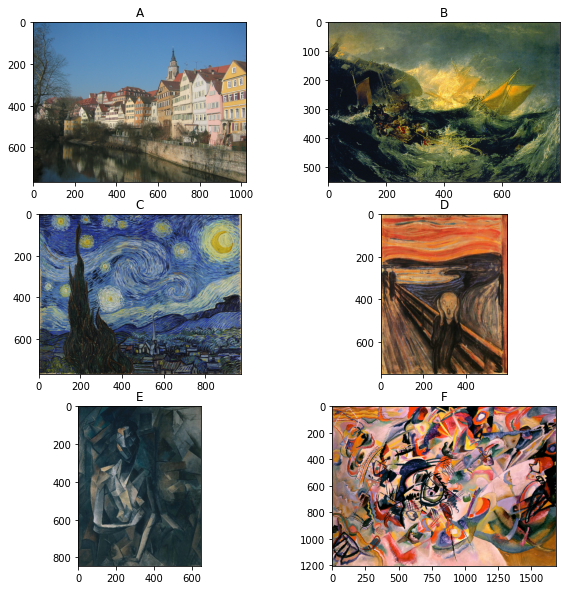

In [ ]:
style_paths = ['minotaur.jpg', 'vangogh_starry_night.jpg', 'scream.jpg', 'femme.jpg', 'compositionVII.jpg']
titles = ['A', 'B', 'C', 'D', 'E', 'F']

content_img = Image.open('Tuebingen_Neckarfront.jpg')
style_imgs = [Image.open(path) for path in style_paths]

plt.subplot(321)
plt.imshow(content_img)
plt.title(titles[0])
for i in range(5):
  plt.subplot(322+i)
  plt.imshow(style_imgs[i])
  plt.title(titles[i+1])
plt.gcf().set_size_inches(10,10)

Now we will demonstrate a style representation and content representation by setting $\alpha = 0$ and $\beta = 0$ respectively. We use Starry Night by Van Gogh for the style.

In [ ]:
gen_image = style_transfer(style_imgs[1], content_img, alpha=0, n=500, wn=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Iteration: 100, Loss: 96948.03125
Iteration: 200, Loss: 15530.5673828125
Iteration: 300, Loss: 6778.8427734375
Iteration: 400, Loss: 4381.771484375
Iteration: 500, Loss: 3371.148193359375

Time taken: 1 minutes, 35 seconds



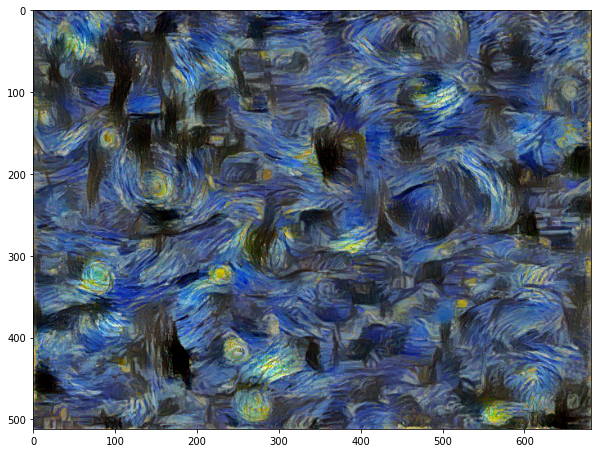

In [ ]:
plt.imshow(gen_image)
plt.gcf().set_size_inches(10,10)

Generating a content representation of Tuebingen Neckarfront

In [ ]:
gen_image = style_transfer(style_imgs[0], content_img, alpha=1, beta=0, n=500, wn=True)

Iteration: 100, Loss: 216.20037841796875
Iteration: 200, Loss: 85.73589324951172
Iteration: 300, Loss: 53.56694793701172
Iteration: 400, Loss: 39.32450485229492
Iteration: 500, Loss: 31.301115036010742

Time taken: 1 minutes, 18 seconds



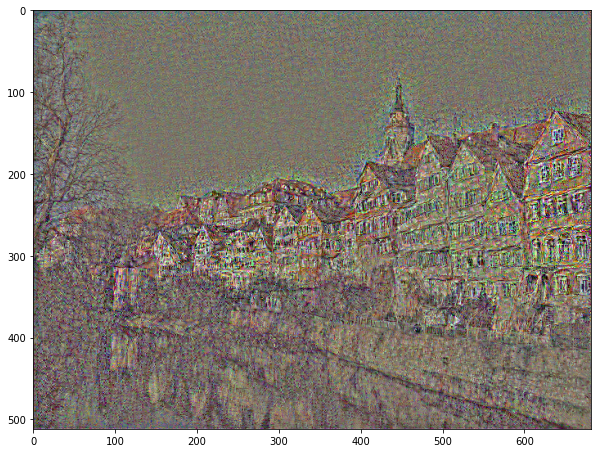

In [ ]:
plt.imshow(gen_image)
plt.gcf().set_size_inches(10,10)

Now we attempt to reproduce Figure 2 from the paper. The authors of the paper used relative weights $\frac{\alpha}{\beta} = 10^{-3}$ for images B-D and $\frac{\alpha}{\beta} = 10^{-4}$ for E and F. Therefore we will set $\alpha = 1$ and use $\beta=10^3$ and $\beta=10^4$ for B-D and E-F respectively.

In [ ]:
#alpha/beta = 10^(-3) for images B, C, D
#alpha/beta = 10^(-4) for images E, F
beta_vals = [1e3, 1e3, 1e3, 1e4, 1e4]

t1 = time.time()
gen_imgs = [style_transfer(style_imgs[i], content_img, alpha=1, beta=beta_vals[i], n=500, wn=False, optim='lbfgs') for i in range(5)]
t2 = time.time()
print("\nTotal time taken: {} minutes, {} seconds\n".format(int((t2-t1)//60), round((t2-t1)%60)))

Iteration: 100, Loss: 17685958.0
Iteration: 200, Loss: 4782037.5
Iteration: 300, Loss: 2736009.5
Iteration: 400, Loss: 1977147.375
Iteration: 500, Loss: 1589244.0

Time taken: 1 minutes, 21 seconds

Iteration: 100, Loss: 13297728.0
Iteration: 200, Loss: 5519600.0
Iteration: 300, Loss: 3716612.0
Iteration: 400, Loss: 2962876.0
Iteration: 500, Loss: 2561550.0

Time taken: 1 minutes, 21 seconds

Iteration: 100, Loss: 44216952.0
Iteration: 200, Loss: 6311869.0
Iteration: 300, Loss: 3477656.25
Iteration: 400, Loss: 2488680.0
Iteration: 500, Loss: 1995412.5

Time taken: 1 minutes, 21 seconds

Iteration: 100, Loss: 202556592.0
Iteration: 200, Loss: 32834860.0
Iteration: 300, Loss: 16880634.0
Iteration: 400, Loss: 11755541.0
Iteration: 500, Loss: 9400321.0

Time taken: 1 minutes, 21 seconds

Iteration: 100, Loss: 1148205312.0
Iteration: 200, Loss: 414594560.0
Iteration: 300, Loss: 278254528.0
Iteration: 400, Loss: 221037376.0
Iteration: 500, Loss: 189776384.0

Time taken: 1 minutes, 21 seconds

Results:

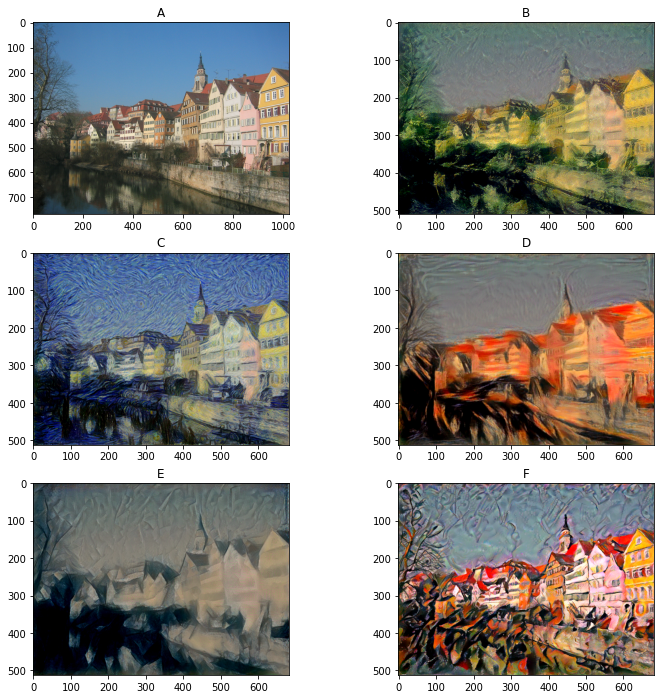

In [ ]:
plt.subplot(321)
plt.imshow(content_img)
plt.title(titles[0])
for i in range(5):
  plt.subplot(322+i)
  plt.imshow(gen_imgs[i])
  plt.title(titles[i+1])
plt.gcf().set_size_inches(12,12)

For Figure 3 we use the artwork 'CompositionVII' and show the effects of using an increasing subset of the style layers and differing values of $\frac{\alpha}{\beta}$. The authors used $\frac{\alpha}{\beta}$ values ranging from $10^{-5}$ to $10^{-2}$, however when attempting to reproduce the results we found that using these values didn't give enough influence to the content image. Therefore we used values of $\frac{\alpha}{\beta}$ ranging from $10^{-3}$ to $10^3$

In [ ]:
beta_vals = [1e3, 1e1, 1e-1, 1e-3]

layers = [[1, 0, 0, 0, 0],
          [1/2, 1/2, 0 ,0, 0],
          [1/3, 1/3, 1/3, 0, 0],
          [1/4, 1/4, 1/4, 1/4, 0],
          [1/5, 1/5, 1/5, 1/5, 1/5]]

art = style_imgs[4]

t1 = time.time()
gen_images = []
for i in range(5):
  gen_images.append([style_transfer(art, content_img, alpha=1, beta=beta_vals[j], wn=True, optim='lbfgs', w=layers[i]) for j in range(4)])
  print('row {} done.\n'.format(i+1))
t2 = time.time()
print("\nTotal time taken: {} minutes, {} seconds\n".format(int((t2-t1)//60), round((t2-t1)%60)))

Iteration: 100, Loss: 38153.92578125
Iteration: 200, Loss: 10103.767578125
Iteration: 300, Loss: 6680.90576171875
Iteration: 400, Loss: 5112.3134765625
Iteration: 500, Loss: 4239.08642578125

Time taken: 1 minutes, 20 seconds

Iteration: 100, Loss: 8471004.0
Iteration: 200, Loss: 248499.046875
Iteration: 300, Loss: 3001.7490234375
Iteration: 400, Loss: 1443.3272705078125
Iteration: 500, Loss: 952.0699462890625

Time taken: 1 minutes, 16 seconds

Iteration: 100, Loss: 1367.660888671875
Iteration: 200, Loss: 377.234619140625
Iteration: 300, Loss: 234.6820526123047
Iteration: 400, Loss: 174.80670166015625
Iteration: 500, Loss: 140.78060913085938

Time taken: 1 minutes, 19 seconds

Iteration: 100, Loss: 444.91949462890625
Iteration: 200, Loss: 196.00302124023438
Iteration: 300, Loss: 129.74871826171875
Iteration: 400, Loss: 95.28077697753906
Iteration: 500, Loss: 75.63348388671875

Time taken: 1 minutes, 19 seconds

row 1 done.

Iteration: 100, Loss: 302602912.0
Iteration: 200, Loss: 14540

Results:

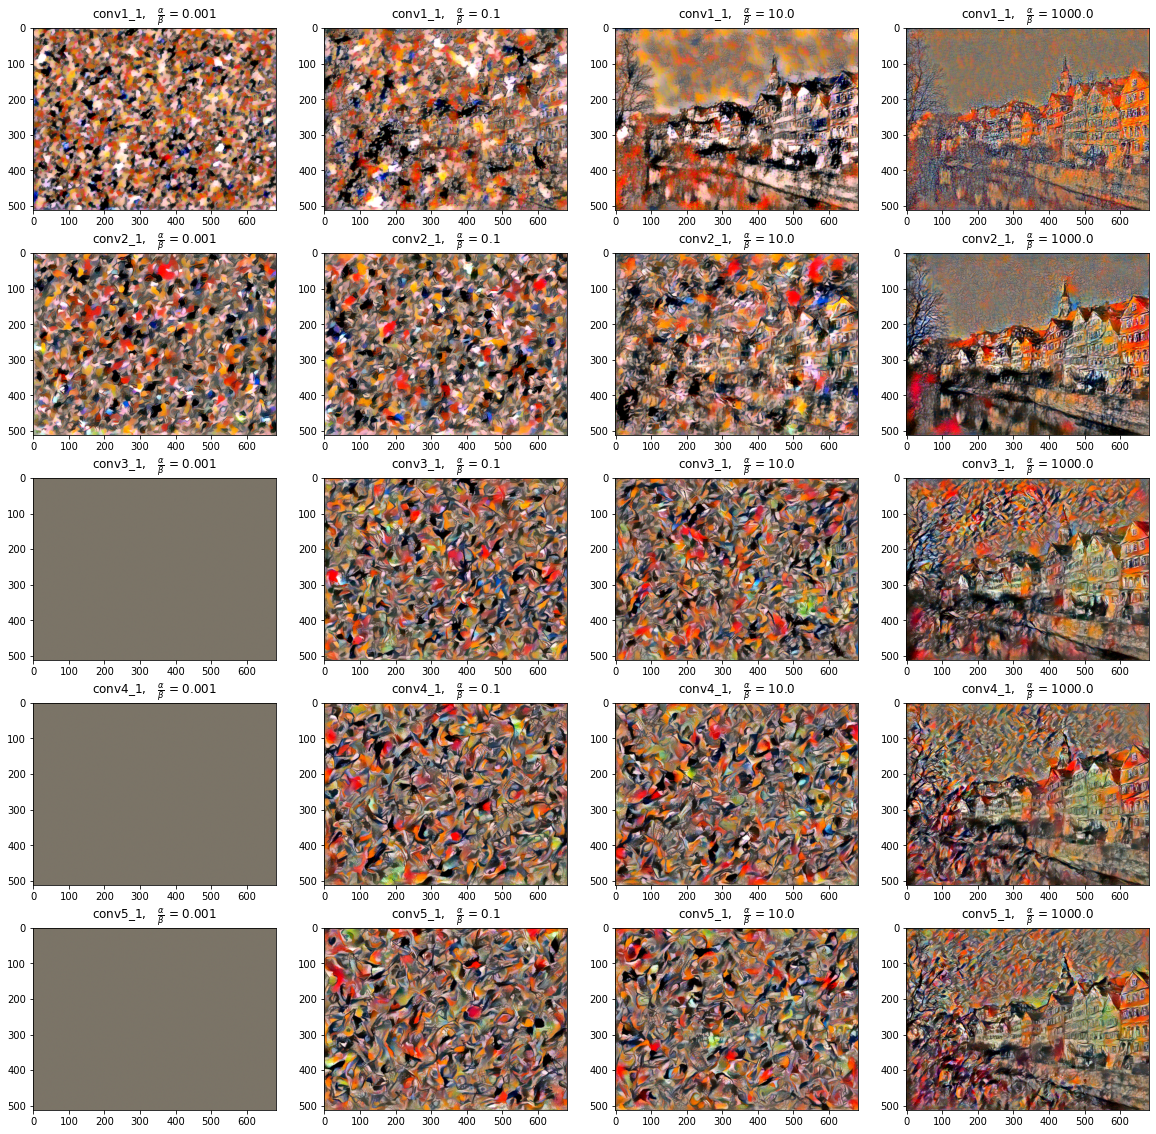

In [ ]:
layer_names = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
for i in range(5):
  for j in range(4):
    plt.subplot2grid((5,4), (i,j))
    plt.imshow(gen_images[i][j])
    plt.title(str(layer_names[i])+r',   $\frac{\alpha}{\beta}$ = '+str(1/beta_vals[j]))
plt.gcf().set_size_inches(20,20)

We can see that the bottom left image got stuck in the gradient descent process. Therefore we generate it again using different values of alpha and beta (but using the same ratio $\frac{\alpha}{\beta}$)

In [ ]:
for i in range(2,5):
  gen_images[i][0] = style_transfer(art, content_img, alpha=1e-1, beta=1e-2, wn=True, optim='lbfgs', w=layers[i])

Iteration: 100, Loss: 92868.1015625
Iteration: 200, Loss: 3532.47802734375
Iteration: 300, Loss: 1348.667724609375
Iteration: 400, Loss: 864.8181762695312
Iteration: 500, Loss: 647.462890625

Time taken: 1 minutes, 19 seconds

Iteration: 100, Loss: 5907.568359375
Iteration: 200, Loss: 2753.400390625
Iteration: 300, Loss: 2134.64404296875
Iteration: 400, Loss: 1902.61279296875
Iteration: 500, Loss: 1769.96435546875

Time taken: 1 minutes, 21 seconds

Iteration: 100, Loss: 813178.5625
Iteration: 200, Loss: 27195.26953125
Iteration: 300, Loss: 3670.1611328125
Iteration: 400, Loss: 2356.268310546875
Iteration: 500, Loss: 1987.9267578125

Time taken: 1 minutes, 18 seconds



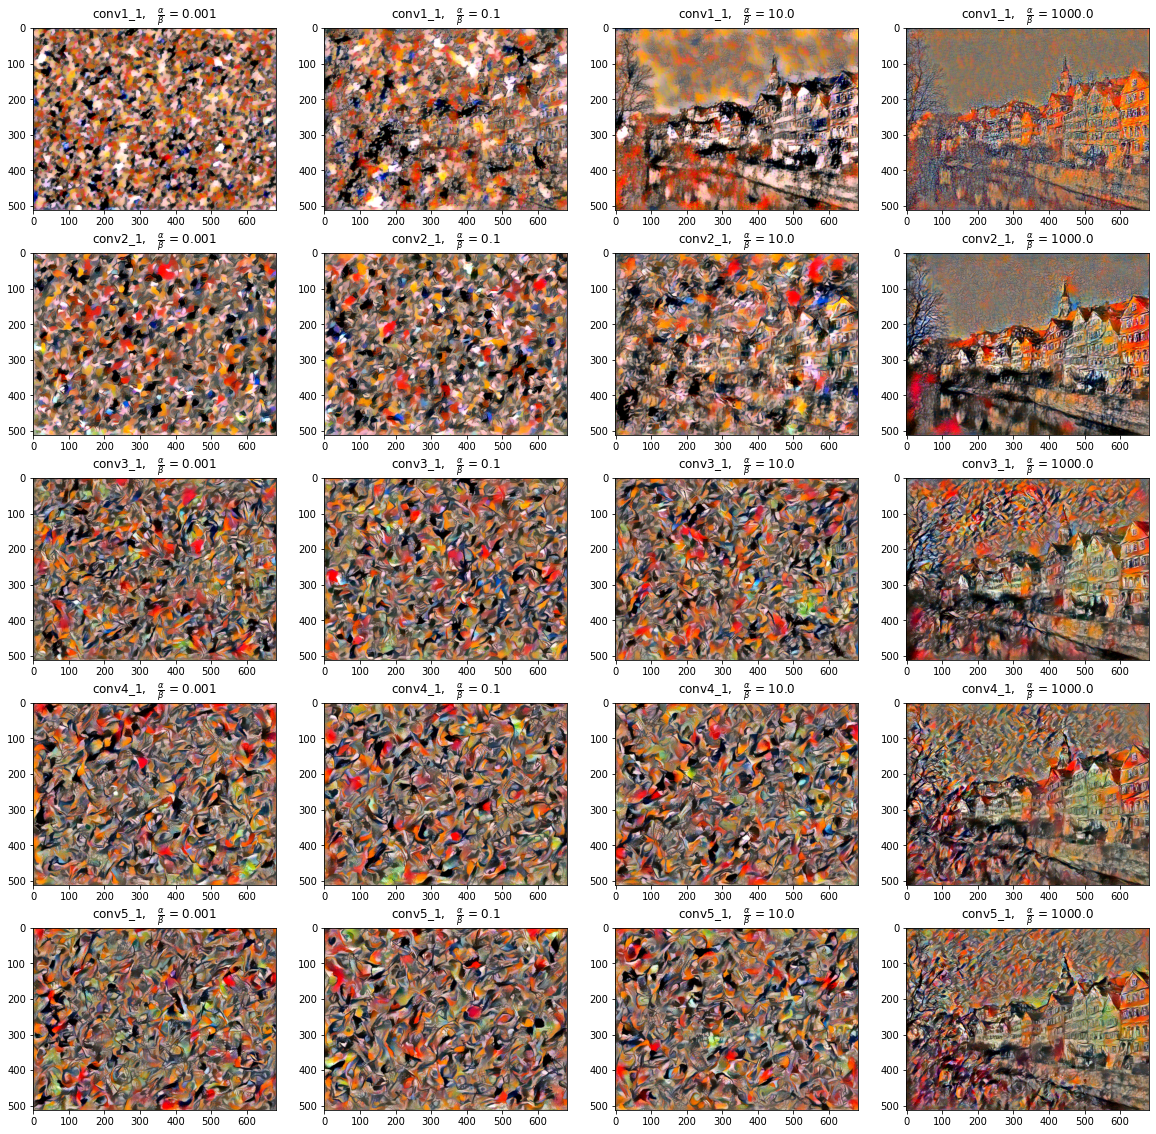

In [ ]:
for i in range(5):
  for j in range(4):
    plt.subplot2grid((5,4), (i,j))
    plt.imshow(gen_images[i][j])
    plt.title(str(layer_names[i])+r',   $\frac{\alpha}{\beta}$ = '+str(1/beta_vals[j]))
plt.gcf().set_size_inches(20,20)